# 京东JData算法大赛(3): 探索高潜用户的行为

比赛的题目是高潜用户购买意向预测, 那么理解清楚**什么是高潜用户**对于数据分析,特征抽取,以及之后的建立模型有着至关重要的作用.  
简单来讲,作为训练集的高潜用户应该具有以下特征:
- 必须有购买行为
- 对一个商品购买和其他交互行为(浏览,点击,收藏等)时间差应该**多于一天**  
  因为根据赛题,我们需要预测未来5天的购买情况,那么如果用户对某商品在同一天完成所有的交互行为(包括购买),  
  我们无法从这种交易中指导未来的预测.  
  **更新Note**: 可能存在买了又买的情况，这部分用户也不可忽略.

那么接下来,让我们先尝试找出这些高潜用户,之后对他们的行为做一些数据分析.

In [1]:
# 导入相关包
%matplotlib inline
# 绘图包
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 定义文件名
ACTION_201602_FILE = "/input/JData_Action_201602.csv"
ACTION_201603_FILE = "/input/JData_Action_201603.csv"
ACTION_201604_FILE = "/input/JData_Action_201604.csv"
COMMENT_FILE = "/input/JData_Comment.csv"
PRODUCT_FILE = "/input/JData_Product.csv"
USER_FILE = "/input/JData_User.csv"
NEW_USER_FILE = "/input/JData_User_New.csv"
USER_TABLE_FILE = "/input/user_table.csv"
BUY_USER_LIST_FILE = "/input/buy_user_list.csv"
PROTENTIAL_USER_RECORD = "/input/protential_user_record.csv"

### 寻找具有购买记录的用户

In [2]:
#　在一个文件中寻找有购买记录的用户－商品对
def buy_user_in_batch_data(fname, chunk_size=100000):
    reader = pd.read_csv(fname, header=0, iterator=True)
    chunks = []
    loop = True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["user_id", "sku_id", "type"]]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped")

    df_ac = pd.concat(chunks, ignore_index=True)

    # type = 4, 购买
    df_ac = df_ac[df_ac['type'] == 4][["user_id", "sku_id"]]

    return df_ac

In [3]:
# 找出有购买记录的用户，并写到csv文件
def find_buy_user():
    df_ac = []
    df_ac.append(buy_user_in_batch_data(fname=ACTION_201602_FILE))
    df_ac.append(buy_user_in_batch_data(fname=ACTION_201603_FILE))
    df_ac.append(buy_user_in_batch_data(fname=ACTION_201604_FILE))
    
    # 将多个子记录合并成一个dataframe
    df_ac = pd.concat(df_ac, ignore_index=True)
    # 将重复的用户－商品对丢弃
    df_ac = df_ac.drop_duplicates()
    # 写入文件
    df_ac.to_csv(BUY_USER_LIST_FILE, index=False)

In [4]:
# 执行程序
find_buy_user()

Iteration is stopped
Iteration is stopped
Iteration is stopped


In [5]:
# 在一个文件中寻找与给定的user-item对有关的所有记录
def ui_record_in_batch_data(fname, ui_pair, chunk_size=100000):
    reader = pd.read_csv(fname, header=0, iterator=True)
    chunks = []
    loop = True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["user_id", "sku_id", "time", "type"]]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped")

    df_ac = pd.concat(chunks, ignore_index=True)
    
    df = []
    for index, row in ui_pair.iterrows():
        usr_id = row["user_id"]
        sku_id = row["sku_id"]

        # 寻找与user-item对有关的所有记录
        df.append(df_ac[(df_ac["user_id"] == usr_id) &
                        (df_ac["sku_id"] == sku_id)])

    df = pd.concat(df, ignore_index=True)
    return df

In [6]:
# apply功能函数：根据一个user-item对的所有记录，计算当前是否是高潜用户
def more_than_a_day(group):
    # 最后一次购买该商品的日期
    last_buy_day = max(group[group["type"] == 4]["date"])
    # 最早与该商品发生交互的日期
    earliest_behave_day = min(group["date"])
    
    # 如果间隔不小于１天，则认为是高潜用户
    if (last_buy_day - earliest_behave_day).days > 0:
        # 字段potential_flag代表是否是高潜用户
        group["potential_flag"] = 1
    else:
        group["potential_flag"] = 0

    return group

In [ ]:
# 寻找高潜用户，并将相关行为记录写入文件
def find_potential_user():
    # 有购买行为的user-item对
    ui_pair = pd.read_csv(BUY_USER_LIST_FILE, header=0)

    df_ac = []
    df_ac.append(ui_record_in_batch_data(ACTION_201602_FILE, ui_pair))
    df_ac.append(ui_record_in_batch_data(ACTION_201603_FILE,ui_pair))
    df_ac.append(ui_record_in_batch_data(ACTION_201604_FILE,ui_pair))

    df_ac = pd.concat(df_ac, ignore_index=True)
    # 丢弃重复的
    df_ac = df_ac.drop_duplicates()
    
    # 增加日期属性
    df_ac['date'] = pd.to_datetime(df_ac['time']).dt.date
    df_ac = df_ac.groupby(["user_id", "sku_id"]).apply(more_than_a_day)
    
    # 找出高潜用户
    df_ac = df_ac[df_ac["potential_flag"] == 1]
    # 写入文件
    df_ac.to_csv(PROTENTIAL_USER_RECORD, index=False)

In [ ]:
%%time
# 这一步特别耗时，需要优化
find_potential_user()

Iteration is stopped
Iteration is stopped
Iteration is stopped
CPU times: user 2h 11min 2s, sys: 32min 13s, total: 2h 43min 16s
Wall time: 2h 43min 15s


### 高潜用户行为轨迹分析

间隔几天的所有交互次数曲线图(可能存在衰减)

In [12]:
ui_record = pd.read_csv(PROTENTIAL_USER_RECORD, header=0)
ui_record.head()

,user_id,sku_id,time,type,date,potential_flag
0,260731,113675,2016-02-01 00:02:31,1,2016-02-01,1
1,260731,113675,2016-02-01 00:02:31,6,2016-02-01,1
2,260731,113675,2016-02-01 00:06:15,6,2016-02-01,1
3,260731,113675,2016-02-01 00:06:15,1,2016-02-01,1
4,260731,113675,2016-02-01 00:16:36,1,2016-02-01,1


In [17]:
# 以某个用户为例
user_id = 260731
cu_record = ui_record[(ui_record['user_id'] == user_id)]
cu_record.tail()

,user_id,sku_id,time,type,date,potential_flag
353742,260731,113675,2016-03-10 22:41:00,1,2016-03-10,1
353743,260731,113675,2016-03-10 22:41:00,6,2016-03-10,1
353744,260731,113675,2016-03-10 22:41:21,6,2016-03-10,1
353745,260731,113675,2016-03-13 17:08:59,6,2016-03-13,1
353746,260731,113675,2016-03-13 17:09:31,1,2016-03-13,1


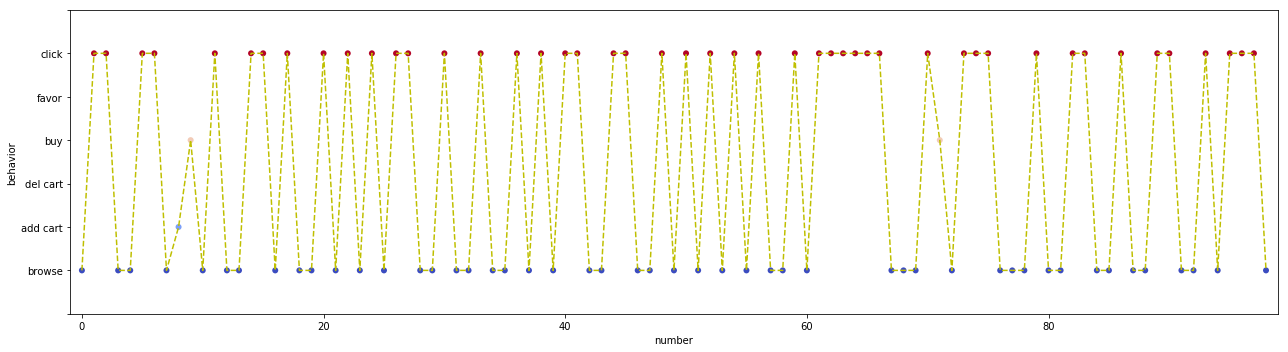

In [18]:
time_range = pd.to_datetime(cu_record['time']).map(lambda x: x.strftime('%m-%d %H:%M'))
x_index = range(len(cu_record['type']))
# 设置图片大小
plt.figure(figsize=(18,5))
plt.scatter(x_index, cu_record['type'],c=cu_record['type'], s=36, lw=0, cmap=plt.cm.coolwarm)
plt.plot(x_index, cu_record['type'], 'y--', markersize=1)
plt.xlim(min(x_index) - 1, max(x_index) + 1)
plt.ylim(0, 7)
plt.xlabel('number')
plt.ylabel('behavior')
# plt.xticks(range(len(cu_record['type'])), time_range, rotation='vertical', fontsize=8)
plt.yticks(range(0,8), ["","browse","add cart","del cart","buy","favor", "click"])
plt.tight_layout()

In [19]:
# 以某个用户对某个商品为例
item_id = 113675
cu_record = ui_record[(ui_record['user_id'] == user_id) & (ui_record['sku_id'] == item_id)]

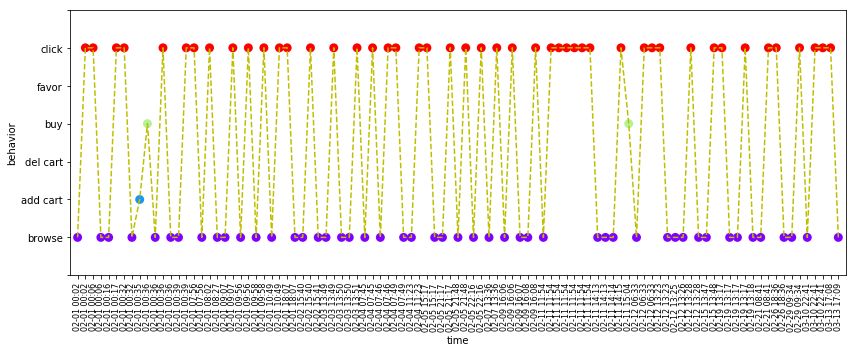

In [20]:
time_range = pd.to_datetime(cu_record['time']).map(lambda x: x.strftime('%m-%d %H:%M'))
x_index = range(len(cu_record['type']))
# 设置图片大小
plt.figure(figsize=(12,5))
plt.scatter(x_index, cu_record['type'],c=cu_record['type'], s=80, lw=0, cmap=plt.cm.rainbow)
plt.plot(x_index, cu_record['type'], 'y--', markersize=1)
plt.xlim(min(x_index) - 1, max(x_index) + 1)
plt.ylim(0, 7)
plt.xlabel('time')
plt.ylabel('behavior')
plt.xticks(range(len(cu_record['type'])), time_range, rotation='vertical', fontsize=8)
plt.yticks(range(0,8), ["","browse","add cart","del cart","buy","favor", "click"])
plt.tight_layout()